In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
import pickle

from IPython.core.display import HTML
import shap

np.random.seed(42)

In [2]:
data = pd.read_csv('data/heart_cleveland_upload.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [36]:
data.oldpeak.min()

0.0

In [3]:
def describe_binary(df : pd.DataFrame, column : str):
    if column not in df.columns:
        print("Wrong column")
        return
    for target in df[column].unique():
        print(target)
        display(HTML((df.query(f"{column} == @target")).describe().T.to_html()))

In [4]:
describe_binary(data, "condition")

0


,count,mean,std,min,25%,50%,75%,max
age,160.0,52.64375,9.551151,29.0,44.75,52.0,59.00,76.0
sex,160.0,0.55625,0.498386,0.0,0.00,1.0,1.00,1.0
cp,160.0,1.79375,0.925508,0.0,1.00,2.0,2.00,3.0
trestbps,160.0,129.17500,16.373990,94.0,120.00,130.0,140.00,180.0
chol,160.0,243.49375,53.757550,126.0,208.75,235.5,268.25,564.0
fbs,160.0,0.14375,0.351938,0.0,0.00,0.0,0.00,1.0
restecg,160.0,0.84375,0.987640,0.0,0.00,0.0,2.00,2.0
thalach,160.0,158.58125,19.043304,96.0,149.00,161.0,172.00,202.0
exang,160.0,0.14375,0.351938,0.0,0.00,0.0,0.00,1.0
oldpeak,160.0,0.59875,0.787160,0.0,0.00,0.2,1.10,4.2


1


,count,mean,std,min,25%,50%,75%,max
age,137.0,56.759124,7.899670,35.0,53.0,58.0,62.0,77.0
sex,137.0,0.817518,0.387658,0.0,1.0,1.0,1.0,1.0
cp,137.0,2.583942,0.828201,0.0,3.0,3.0,3.0,3.0
trestbps,137.0,134.635036,18.896730,100.0,120.0,130.0,145.0,200.0
chol,137.0,251.854015,49.679937,131.0,218.0,253.0,284.0,409.0
fbs,137.0,0.145985,0.354387,0.0,0.0,0.0,0.0,1.0
restecg,137.0,1.175182,0.976924,0.0,0.0,2.0,2.0,2.0
thalach,137.0,139.109489,22.710673,71.0,125.0,142.0,157.0,195.0
exang,137.0,0.540146,0.500215,0.0,0.0,1.0,1.0,1.0
oldpeak,137.0,1.589051,1.305006,0.0,0.6,1.4,2.5,6.2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


Все признаки вещественные

In [6]:
data.shape

(297, 14)

#### Препроцессинг

In [7]:
data.isna().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

Пропусков нет, соответсвенно их заполнять не надо

In [8]:
def print_targets(df : pd.DataFrame, column : str): 
    if column not in df.columns:
        print("Wrong column")
    else:
        vals = pd.DataFrame(df[column].value_counts())
        vals["%"] = vals[column].map(lambda x: round(x / vals[column].sum(), 2))
        print(vals)

In [9]:
print_targets(data, "condition")

   condition     %
0        160  0.54
1        137  0.46


Нет дисбаланса классов

In [10]:
X = data.drop('condition', axis = 1)
y = data.condition
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Проверим мультиколлинеарность

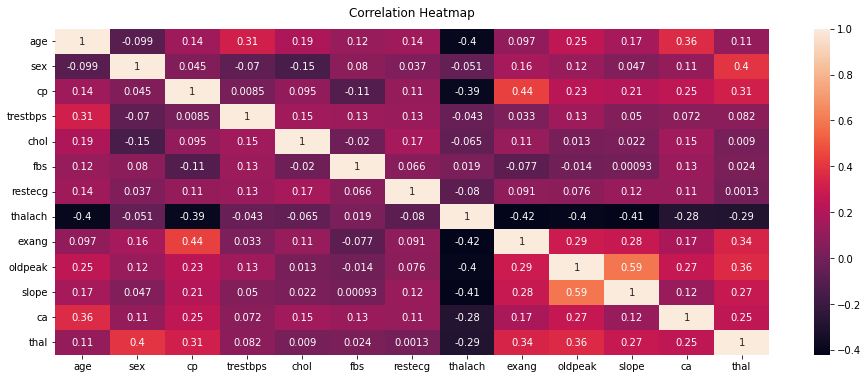

In [11]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(X_train.corr(method="spearman"), annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Колонки chol, restecg не коррелируют с таргетом, вероятно, они не нужны

In [12]:
X_train = X_train.drop(["chol", "restecg"], axis=1)
X_test = X_test.drop(["chol", "restecg"], axis=1)

In [13]:
def standartize(df: pd.DataFrame, df_mean=None, df_std=None) -> pd.DataFrame:
    df_mean = df.mean() if df_mean is None else df_mean
    df_std = df.std() if df_std is None else df_std
    return (df-df_mean)/df_std

In [14]:
mean = X_train.mean()
std = X_train.std()

In [15]:
(X_train-mean.values)/std.values

,age,sex,cp,trestbps,fbs,thalach,exang,oldpeak,slope,ca,thal
111,-0.064633,0.699842,-0.176185,1.127185,-0.406592,0.684350,-0.693919,0.484376,-0.983863,-0.719245,1.226079
219,0.377856,-1.423542,0.869177,2.316508,2.450254,-0.152206,1.435694,1.519694,0.647760,1.402726,0.183521
24,1.815945,-1.423542,-1.221546,1.721846,-0.406592,0.552262,-0.693919,-0.550941,-0.983863,1.402726,-0.859037
82,1.262834,-1.423542,-0.176185,0.889320,-0.406592,0.111969,-0.693919,-0.896047,0.647760,0.341741,-0.859037
7,0.709723,0.699842,-2.266908,0.175726,-0.406592,-0.196235,-0.693919,1.347141,0.647760,1.402726,-0.859037
...,...,...,...,...,...,...,...,...,...,...,...
188,0.820345,-1.423542,0.869177,0.532523,-0.406592,0.332116,-0.693919,0.139270,0.647760,-0.719245,-0.859037
71,-2.830189,0.699842,-1.221546,-0.062139,-0.406592,2.313432,-0.693919,-0.896047,-0.983863,-0.719245,-0.859037
106,0.156611,0.699842,-0.176185,-0.062139,2.450254,-0.328323,1.435694,-0.378389,0.647760,0.341741,0.183521
270,-0.838989,0.699842,0.869177,-1.251462,-0.406592,-1.385025,1.435694,-0.033283,0.647760,0.341741,-0.859037


In [16]:
X_train = standartize(X_train, mean, std)
X_test = standartize(X_test, mean, std)

In [17]:
X_train

,age,sex,cp,trestbps,fbs,thalach,exang,oldpeak,slope,ca,thal
111,-0.064633,0.699842,-0.176185,1.127185,-0.406592,0.684350,-0.693919,0.484376,-0.983863,-0.719245,1.226079
219,0.377856,-1.423542,0.869177,2.316508,2.450254,-0.152206,1.435694,1.519694,0.647760,1.402726,0.183521
24,1.815945,-1.423542,-1.221546,1.721846,-0.406592,0.552262,-0.693919,-0.550941,-0.983863,1.402726,-0.859037
82,1.262834,-1.423542,-0.176185,0.889320,-0.406592,0.111969,-0.693919,-0.896047,0.647760,0.341741,-0.859037
7,0.709723,0.699842,-2.266908,0.175726,-0.406592,-0.196235,-0.693919,1.347141,0.647760,1.402726,-0.859037
...,...,...,...,...,...,...,...,...,...,...,...
188,0.820345,-1.423542,0.869177,0.532523,-0.406592,0.332116,-0.693919,0.139270,0.647760,-0.719245,-0.859037
71,-2.830189,0.699842,-1.221546,-0.062139,-0.406592,2.313432,-0.693919,-0.896047,-0.983863,-0.719245,-0.859037
106,0.156611,0.699842,-0.176185,-0.062139,2.450254,-0.328323,1.435694,-0.378389,0.647760,0.341741,0.183521
270,-0.838989,0.699842,0.869177,-1.251462,-0.406592,-1.385025,1.435694,-0.033283,0.647760,0.341741,-0.859037


### Обучение

In [18]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print("\tcrossval: ", cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc').mean())
print("\t\033[1;32mAUC: \t", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]), " \033[0;0m")
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred), "\n")

	crossval:  0.9040952380952382
	AUC: 	 0.9263392857142857  
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        16
           1       0.75      0.86      0.80        14

    accuracy                           0.80        30
   macro avg       0.80      0.80      0.80        30
weighted avg       0.81      0.80      0.80        30
 



In [19]:
lgbm = LGBMClassifier(n_estimators = 200, random_state=42)
lgbm.fit(X_train, y_train)
print("\tcrossval: ", cross_val_score(lgbm, X_train, y_train, cv=5, scoring='roc_auc').mean())
print("\t\033[1;32mAUC: \t", roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1]), " \033[0;0m")
y_pred = lgbm.predict(X_test)
print(classification_report(y_test, y_pred), "\n")

	crossval:  0.8902052545155994
	AUC: 	 0.8705357142857143  
              precision    recall  f1-score   support

           0       0.85      0.69      0.76        16
           1       0.71      0.86      0.77        14

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.77        30
weighted avg       0.78      0.77      0.77        30
 



In [21]:
xgb = XGBClassifier(use_label_encoder=False, verbosity=0, random_state=42)
xgb.fit(X_train, y_train)
print("\tcrossval: ", cross_val_score(xgb, X_train, y_train, cv=5, scoring='roc_auc').mean())
print("\t\033[1;32mAUC: \t", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]), " \033[0;0m")
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred), "\n")

	crossval:  0.8868292282430212
	AUC: 	 0.8839285714285714  
              precision    recall  f1-score   support

           0       0.79      0.69      0.73        16
           1       0.69      0.79      0.73        14

    accuracy                           0.73        30
   macro avg       0.74      0.74      0.73        30
weighted avg       0.74      0.73      0.73        30
 



In [22]:
cb = CatBoostClassifier(verbose=None, silent=True, logging_level=None, random_state=42)
cb.fit(X_train, y_train)
print("\tcrossval: ", cross_val_score(cb, X_train, y_train, cv=5, scoring='roc_auc').mean())
print("\t\033[1;32mAUC: \t", roc_auc_score(y_test, cb.predict_proba(X_test)[:, 1]), " \033[0;0m")
y_pred = pd.Series(cb.predict(X_test)).replace({'True':1, 'False':0} )
print(classification_report(y_test, y_pred))

	crossval:  0.9165779967159278
	AUC: 	 0.9285714285714286  
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        16
           1       0.75      0.86      0.80        14

    accuracy                           0.80        30
   macro avg       0.80      0.80      0.80        30
weighted avg       0.81      0.80      0.80        30



In [23]:
# filename_pkl = 'orby_model.pkl'
# filename_bin = 'orby_model.bin'
# pickle.dump(lgbm, open(filename_pkl, 'wb'))
# pickle.dump(lgbm, open(filename_bin, 'wb'))

In [24]:
# loaded_model_pkl = pickle.load(open(filename_pkl, 'rb'))
# loaded_model_bin = pickle.load(open(filename_bin, 'rb'))